# Atmospheric Dispersion Examples

This notebook will demonstrate how to compute the effects of atmospheric refraction for solar observations. 

atmospheric_density: Given temperature, pressure, etc., return atmospheric density (needed for refractivity)

refractivity: Given temperature, pressure, etc., return refractivity (needed for atmospheric_refraction)

atmospheric_refraction: Compute magnitude of refraction and parallactic angle for given wavelengths at given times

offsets: Compute refraction offsets in solar disk NS-EW coordinates

## Load important modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import astropy.units as u
from astropy import coordinates
from astropy.coordinates import EarthLocation, AltAz, TETE
from astropy.coordinates.erfa_astrom import erfa_astrom, ErfaAstromInterpolator
from astropy.time import Time
from astropy.table import Table
from astropy.io import fits
import sunpy as sp
from sunpy import coordinates as coord

import atm_dispersion as adm # Atmospheric Dispersion Module

All modules loaded


## Example 1: calculate refractivity for a single wavelength

In [2]:
# "average" atmospheric conditions on Haleakala
temp = 11.*u.deg_C
pressure = 71100*u.pascal
humidity = 30.0     # percent
co2 = 380.      # ppm

# wavelength(s) for which refractivity will be computed; in this case, the calcium H line
wavelengths = np.array([396.9])*u.nm

refrac = adm.refractivity(wavelengths,
                          temp,
                          pressure,
                          humidity,
                          co2,
                          verbose=2)

print("Refractivity (n-1) = {:.5g}".format(refrac[0])) # print refractivity to 5 sig. figs.

density a -  0.8670712923452407 1.2254226533684582 0.7075691721234494
density w -  0.003013028303143761 0.009859381090734688 0.30560014623790555
n(axs):  [28291.41881446] 
n(ws):  [318.58190157] 
rho(a/axs):  0.7075691721234494 
rho(w/ws):  0.30560014623790555 
n(prop):  [20115.49446446]
n(air):  [20018.13578875] 
n(water):  [97.35867571]
Refractivity (n-1) = 0.00020115


## Example 2: compute atmospheric refraction for a range of wavelengths at a single time

In [3]:
# First, we need to define our observing location

# Default will be to use DKIST as the location
# but any other location could be used by manually setting the geodetic coordinates

set_location_dkist = True

if set_location_dkist:
    observing_loc = EarthLocation.of_site('dkist')
    observing_loc.info.meta['name'] = 'DKIST'
    # these are the average atmospheric conditions on Haleakalā
    atm_conditions = {
        'temp': 8.2*u.deg_C,
        'pressure': 70965.*u.Pa,
        'humidity': 30,
        'co2_conc': 400}

else:
    longitude =    -156.25*u.deg
    latitude  =     20.71*u.deg
    altitude  =     0.*u.m
    observing_loc = EarthLocation(lat=latitude, lon=longitude, height=altitude)
    # these are the conditions for the standard atmosphere
    atm_conditions = {'temp':15*u.deg_C, 'pressure':101325.*u.Pa, 'humidity':0, 'co2_conc':314}

print("Observing Location -- longitude: {:0.4f} ; latitude: {:0.4f} ; altitude: {:0.0f} "\
      .format(observing_loc.geodetic.lon, observing_loc.geodetic.lat, observing_loc.geodetic.height))


Observing Location -- longitude: -156.2564 deg ; latitude: 20.7067 deg ; altitude: 3067 m 


Text(0.5, 1.0, 'Total Atmosphere Refraction')

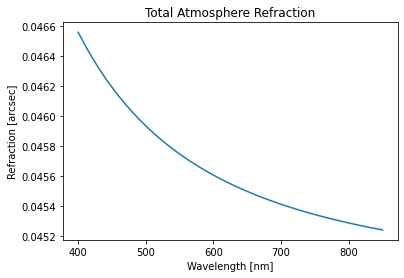

In [4]:
# This section calculates the absolute refraction 

# series of wavelengths, ranging from 400 to 850 nm
wavelengths = (np.arange(46)*10 + 400)*u.nm

# time for which refraction will be computed; note that Hawaii time is UTC-10
#time = Time('2021-05-23 17:00:00', scale='utc') + np.zeros((1))

# at this time the Sun is nearly at the zenith
time = Time('2021-05-23 22:21:40',scale='utc') + np.zeros((1))

time.format = 'jd'

# Compute dispersion for given times and wavelengths
refraction = adm.atmospheric_refraction(wavelengths,
                                        time,
                                        air_pressure=atm_conditions['pressure'],
                                        air_temp=atm_conditions['temp'], 
                                        humidity=atm_conditions['humidity'],
                                        co2_conc=atm_conditions['co2_conc'],
                                        observer_location=observing_loc,
                                        verbose=0)

# Plot refraction as a function of wavelength
plt.plot(wavelengths.value, refraction[0]['refraction_mag (arcsec)'][0])

plt.xlabel('Wavelength [nm]')
plt.ylabel('Refraction [arcsec]')
plt.title('Total Atmosphere Refraction')



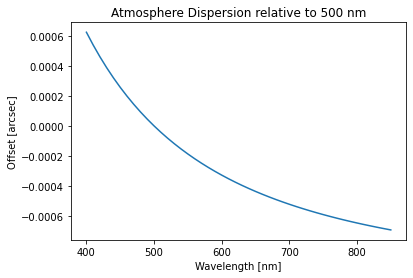

In [5]:
# Now let's calculate the dispersion, the relative difference in refraction between two different wavelengths

ref_wave = (np.zeros(len(wavelengths)) + 5000*u.AA)

idx_500nm = np.argmin(abs(wavelengths - ref_wave))
refraction_abs = refraction[0]['refraction_mag (arcsec)']

dispersion_ref500nm = refraction_abs - refraction_abs[0, idx_500nm]

plt.plot(wavelengths.value, dispersion_ref500nm[0,:])
plt.xlabel('Wavelength [nm]')
plt.ylabel('Offset [arcsec]')
plt.title('Atmosphere Dispersion relative to {:n}'.format(ref_wave[0].to(u.nm)))

max_dispersion = np.max(dispersion_ref500nm)


## Example 3: compute dispersion-induced offsets in solar NS-EW coordinates

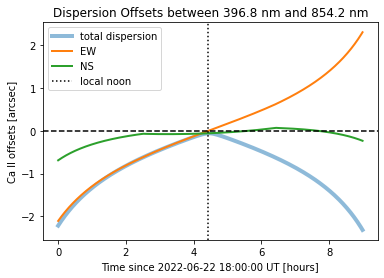

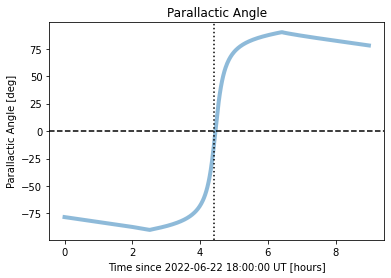

In [16]:
# Choose two wavelengths: we'll use the calcium lines at 397 and 854 nm
wavelengths = np.array([396.8, 854.2]) * u.nm

# We'll use the same location, but this time we'll calculate how the values change over several hours.
# Again, note that Hawaii time is UTC-10, so e.g. 18:00 UTC is 08:00 a.m. in Hawaii.
times = Time('2022-06-22 18:00:00', scale='utc') + np.arange(60*9)*u.min
times.format = 'jd'
noon_idx = int(np.where(np.modf((times - 10*u.hour).value)[0] == 0)[0][0]
               + (15 - observing_loc.geodetic.lon.value % 15)*4)

# Compute offsets
(offsets, refraction_atm, coords) = adm.offsets(wavelengths,
                                        times,
                                        air_pressure=atm_conditions['pressure'],
                                        air_temp=atm_conditions['temp'],
                                        humidity=atm_conditions['humidity'],
                                        co2_conc=atm_conditions['co2_conc'], 
                                        observer_location=observing_loc,
                                        verbose=0)

dispersion_relative = ((refraction_atm['refraction_mag (arcsec)'])[:,1]
                       - (refraction_atm['refraction_mag (arcsec)'])[:,0])
parallactic_angle   = refraction_atm['parallactic_angle (degrees)']

EW = offsets['East-West']
NS = offsets['North-South']

T_delta = times - times[0]

# Make a plot of total dispersion, and dispersion broken down into solar geocentric coordinates
plt.figure(1)
plt.plot(T_delta.value*24, dispersion_relative, label='total dispersion', linewidth=4, alpha=0.5)
plt.plot(T_delta.value*24, EW[:,0] - EW[:,1], label='EW', linewidth=2)
plt.plot(T_delta.value*24, NS[:,0] - NS[:,1], label='NS', linewidth=2)

plt.axhline(0, color='k', linestyle='--')
plt.axvline(T_delta[noon_idx].value*24, color='k', linestyle=':', label='local noon')

plt.xlabel('Time since ' + times[0].strftime('%Y-%m-%d %H:%M:%S') + ' UT [hours]')
plt.ylabel('Ca II offsets [arcsec]')
plt.title('Dispersion Offsets between {:0.1f} and {:0.1f}'.format(wavelengths[0], wavelengths[1]))
plt.legend()

# Now make a plot of parallactic angle (which is wavelength independent)
plt.figure(2)
plt.plot(T_delta.value*24, parallactic_angle, label='parallactic angle', linewidth=4, alpha=0.5)
plt.axhline(0, color='k', linestyle='--')
plt.axvline(T_delta[noon_idx].value*24, label='local noon', color='k', linestyle=':')

plt.xlabel('Time since ' + times[0].strftime('%Y-%m-%d %H:%M:%S') + ' UT [hours]')
plt.ylabel('Parallactic Angle [deg]')
plt.title('Parallactic Angle')

noon_values = (dispersion_relative[noon_idx], parallactic_angle[noon_idx])